In [1]:
from neuroaiengines.networks.ring_attractor import RingAttractorPytorch
from neuroaiengines.utils.signals import create_epg_bump_fn, shuffle_ring, create_preferred_angles, create_decoding_fn, wrap_pi
from neuroaiengines.networks import create_symmetric_hemi_ra_matrix
import torch
from torch import tensor,nn
import numpy as np
import matplotlib.pyplot as plt

# Ring attractor structure
The ring attractor is a neural circuit found in many insects that keeps track of the insect's heading. In the _D. melanogaster_ it is mainly composed of four populations of neurons whose synapses form a literal ring. The functional properties are for each of the neurons is theorized to be:
* EPG: Keep track of the heading -- the output neurons
* PEN: shift the heading estimate clockwise or counterclockwise 
* PEG: Maintain the estimate over time
* Pintr (also known as $\Delta7$): Provides inhibition to the other neuron populations 

![ra](./images/RA_architecture.png)


The above figure shows the functional layout of the circuit. 

A shows how each population is connected to each other, and the functional inputs (angular velocity and visual features).

B shows the wedge like structure of the ring attractor. Each wedge is composed of two neurons (left and right hemispheres) of each excitatory neuron type. 

C shows how the two hemispheres can be seperated for clarity.

D shows how the visual features are integrated. $W^{r \rightarrow c}$ is a weight matrix that translates the N input features into 16 currents that get injected into the EPG neurons.

# Ring attractor function
The heading of the insect is estimated by the ring attractor as a pattern of activation, which looks like a locus, or "bump", of synaptic activity along the ring. We can model that as a circular gaussian (von mises function) distrubution. That is to say, if the insect is facing 45º (relative to some arbitrary starting point), there will be a bump of activity at 45º on the ring. We can therefore write a function to convert angle into a distribution that shows the theorized activity in each of the EPG neurons. 

In [2]:
# We first define how many EPGs per hemisphere we want. In the fruit fly, there are 8, but we can construct any sized ring attractor!
N_EPG = 8
bump_fn = create_epg_bump_fn(
    N_EPG, 
    # We define the width of the gaussian here as full width half max (the width when the distrubtion is at half its peak)
    fwhm=np.pi/3,
    # Scaling factor is just a multiplicative factor applied to the distribution.
    scaling_factor=1.,
    # This offset means that the left and right EPGs are shifted slightly from each other. (i.e instead of EPG L 1 and EPG R 1 corresponding to the same angle, EPG L 1 < EPG R 1 < EPG L 2 etc)
    hemisphere_offset=True
    )


Now we can just plot the bump - in this case, at angle 0

Text(0, 0.5, 'Activation')

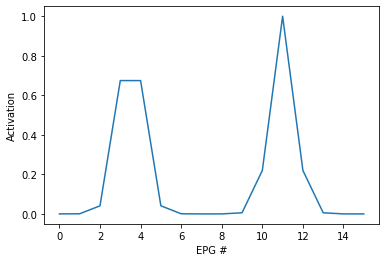

In [3]:
plt.plot(bump_fn(0))
plt.xlabel("EPG #")
plt.ylabel("Activation")

Notice how there are actually two unequal bumps - thats because there are two hemispheres that are shifted. If, however, we plot this and "shuffle" the EPGs, we get a better image of what the bump looks like

Text(0, 0.5, 'Activation')

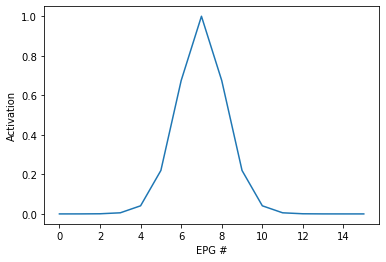

In [4]:
plt.plot(shuffle_ring(bump_fn(0)))
plt.xlabel("EPG #")
plt.ylabel("Activation")

Each neuron has a "preferred" angle, which is the heading at which the neuron fires the most. We can use these preferred directions to make a polar plot.
Below, the radius of each point is the activation level, while its angle is its preferred angle.

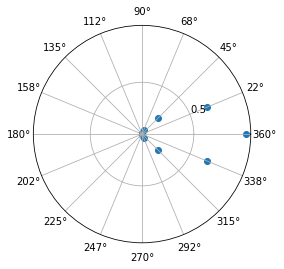

In [5]:
preferred_angles = create_preferred_angles(N_EPG*2,hemisphere_offset=True,centered=True)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(shuffle_ring(preferred_angles),shuffle_ring(bump_fn(0)), marker="o")
ax.set_rticks([0.5])
_ = ax.set_thetagrids(np.rad2deg(shuffle_ring(preferred_angles)+np.pi))

Given this information, we can also construct a "decoding" function that enables the conversion from neuron activity back to an angle. Note, there might be a very small discrepancy due to the way floats work!

In [6]:
decoding_fn = create_decoding_fn(N_EPG,hemisphere_offset=True)
decoding_fn(bump_fn(0))

-7.87907472231639e-18

Now that we understand what the bump looks like, we can make an "initial condition" for our ring attractor that sets all the EPG activities to an initial bump, and all the other neurons to 1.

In [7]:
# First, we load the weight matrix so we know how big it is
# This function creates a weight matrix `w` with the untrained weights as well as a `slcs` object that allows us to index the weight matrix and states by population name

w, slcs = create_symmetric_hemi_ra_matrix(N_EPG,gaussian=True, both=True, null_offset=True)

initial_condition = np.ones(len(w))
# Set the initial state of EPG neurons to be the bump at angle 0
initial_condition[slcs['epg']] = bump_fn(0)
# Make it a tensor for pytorch
initial_condition = tensor(initial_condition)

In [27]:

# Now we can make the ring attractor object with the weight matrix and the population slices
ring_attractor = RingAttractorPytorch(
    # We multiply the weight by an arbitrary low number at first
    tensor(w)*0.0025,
    slcs,
    use_landmarks=True,
    no_ipsi_contra_split=['d7']
)
# Now, we can load the trained model, which is just scaling factors on the weights for each population/hemisphere.
state_dict = torch.load('../examples/null_offset/data/model.pt')

_ = ring_attractor.load_state_dict(state_dict, strict=False)
# Set this manually, since the network wasn't trained on it!
ring_attractor.lm_scaling = nn.Parameter(tensor(1.))

In [28]:
#To give a better understanding of the weights, lets print them.
for key, value in ring_attractor.named_parameters():
    print(key, "==", value.detach().numpy())


v_scaling == -0.5339029
lm_scaling == 1.0
gain.d7 == 1.2019144
gain.epg == 0.253522
gain.peg == 2.6226552
gain.pen == 2.045068
gain.pen-b == 0.0
bias.d7 == 2.4902124
bias.epg == -0.6156889
bias.peg == -0.42914724
bias.pen == -0.91698956
bias.pen-b == 0.0
tau.d7 == -3.912023
tau.epg == -3.912023
tau.peg == -3.912023
tau.pen == -3.912023
tau.pen-b == -3.912023
weights.d7_d7_contra == -2.0599484263640124
weights.d7_d7_ipsi == -2.4416907309996168
weights.d7_pen-b_contra == 0.8691074999701492
weights.d7_pen-b_ipsi == 0.8598465825656708
weights.d7_pen_contra == 0.2906461957876274
weights.d7_pen_ipsi == -0.5162871713573537
weights.epg_d7_contra == 1.0535170896171997
weights.epg_d7_ipsi == 2.2529673178628085
weights.epg_epg_contra == 0.2982774136961574
weights.epg_epg_ipsi == 1.9918037019521881
weights.epg_peg_contra == -0.9291502836235547
weights.epg_peg_ipsi == 1.02820378075584
weights.epg_pen-b_contra == -0.6724581875820936
weights.epg_pen-b_ipsi == 3.502140273799743
weights.epg_pen_contra 

This is a list of all the tuned parameters. Notice beyond just the weights, there are gain and bias trained for each population. In order to prevent some of these parameters from going negative, these are actually the logarithms of the weights. 

Given all this knowledge, we can now go about using the optimized ring attractor.

First, let us construct our inputs into the system - the "visual" input and the velocity input. Note here, the visual input is simply an angle. We will convert this into EPG input currents using our bump function when we run the system. The velocity input here will be constant, but we can change that!

In [29]:
# First lets define the time vector - this is a list of timepoints that we're running the network at. In this case, 0.5s with a time interval of 1ms
dt = 0.001
T = np.arange(0,0.5,dt)
# Moving fast here! This is what the network was trained on, so it will have the best performance. This is in rad/s
velocity_input = 4*np.pi
# We can construct the visual input using the velocity input to integrate a starting angle
angle = 0
landmark_input = []
# This is Euler integration.
for i in T:
    landmark_input.append(angle)
    angle += velocity_input*dt
    


Now that we have our inputs set up, we can actually run the network.

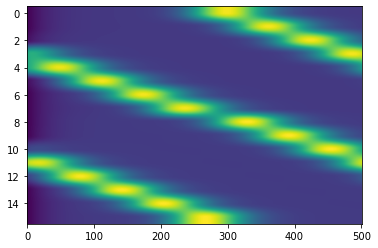

In [30]:
# List of 2-tuple states. The first element of each tuple is the previous state, and the second element is the current state.
states = [(None, initial_condition)]
# This will be our input vector - don't re-initialize it every loop since it will be slow!
inp = np.zeros(18)

# No grad because we dont want to calcuate a gradient (we're not training, just evaluating)
with torch.no_grad():
    
    
    decoded_angles = [0]
    # We iterate over the times as well since it allows us to calculate the timestep if it is not known. Not necessary here, but good practice!

    _t = None
    for lm_inp,t in zip(landmark_input,T):
        # Calculate the timestep from the time and the previous time
        if _t is None:
            dt = 0.001
            
        else:
            dt = t - _t
        _t = t
        # We construct our full input here
        inp[0] = 0.001
        inp[1] = velocity_input
        inp[2:] = bump_fn(lm_inp)
        # Detaching necessary but not super important to know why!
        state = states[-1][1].detach()
        # Calling the ring attractor gets the output (simply the EPG activation) and the activation of all the neurons
        output, new_state = ring_attractor(tensor(inp), state)
        states.append((state, new_state))
        # We now can decode from the output
        decoded_angles.append(decoding_fn(output.detach().numpy()))
    states = np.array([s[1].numpy() for s in states])


Now, lets take a look at the EPG activations

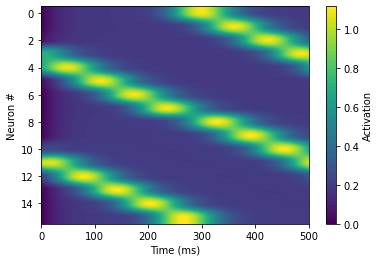

In [33]:
plt.imshow(states.T[slcs['epg'],:], aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('EPG #')
plt.colorbar(label='Activation')

Now we cant take a look at the decoded angles... pretty good!

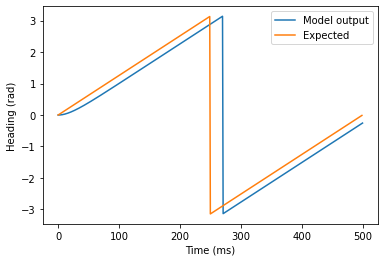

In [35]:
plt.plot(decoded_angles, label='Model output')
plt.plot(wrap_pi(np.array(landmark_input)),label='Expected')
plt.xlabel('Time (ms)')
plt.ylabel('Heading (rad)')
plt.legend()


Note that the output is pretty good since we are injecting current into the neurons we're reading the activation from. Next step here is to use just the velocity input!
TODO